In [4]:
from pylab import *
import numpy as np
import matplotlib, pylab
from dcll.npamlib import plotLIF
from dcll.pytorch_libdcll import *
import os.path as path

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['savefig.dpi']=400.
matplotlib.rcParams['font.size']=14.0
matplotlib.rcParams['figure.figsize']=(5.0,3.5)
matplotlib.rcParams['axes.formatter.limits']=[-10,10]
matplotlib.rcParams['axes.labelsize']= 14.
matplotlib.rcParams['figure.subplot.bottom'] = .2
matplotlib.rcParams['figure.subplot.left'] = .2       

In [5]:
all_layers_folder_id = range(1, 5, 1)
base_folder = "../Paper_results/{:03d}__04-10-2018"
base_folder_begin = "../Paper_results_begin/{:03d}__05-10-2018"
all_layers_folders = [
    base_folder.format(n) for n in all_layers_folder_id
]
all_layers_begin_folders = [
    base_folder_begin.format(n) for n in all_layers_folder_id
]
print(list(all_layers_folder_id))

[1, 2, 3, 4]


In [21]:
import pickle
    
def plot_accuracy(directories, n_updates_tick=1, comment=""):
    args = np.load(path.join(directories[0],"args.pkl"))
    batch_size = args['batch_size']
    n_test_interval = args['n_test_interval']
 
    acc_test = [ np.load(path.join(d, "acc_test.npy")) for d in directories ]
    acc_test = np.array(acc_test)
    
    acc_test_ref = [ np.load(path.join(d, "acc_test_ref.npy")) for d in directories ]
    acc_test_ref = np.array(acc_test_ref)
    
    print("(n_runs, n_epoch/test_interval, n_batch_test, n_layers): {}".format(acc_test.shape))
    n_epoch = (acc_test.shape[1] - 1) * n_test_interval + 1 
    n_layers = acc_test.shape[3]
    
    parameters = pickle.load(open(path.join(directories[0], 'parameters_{}.pkl'.format(n_epoch-1)), 'rb'))
    n_weights = 0
    n_bias = 0
    for k, v in parameters.items():
        if k.endswith('.i2h.weight'):
            n_weights += v.size
        elif k.endswith('.i2h.bias'):
            n_bias +=v.size            
    print("number of trained weights: {} bias: {}".format(n_weights, n_bias))
    print("number of test samples: {}".format(acc_test.shape[2] * batch_size))

    print(acc_test[0, 15, 1, 2])
    test_epochs = np.arange(0, n_epoch, n_test_interval, dtype='int') + 1
    # mean over the multiple test batches
    weighted_acc = np.mean(acc_test, axis=2)
    weighted_acc_ref = np.mean(acc_test_ref, axis=2)
    # mean over the multiple runs with different seeds
    mean_acc = np.mean(weighted_acc, axis=0)
    std_acc = np.std(weighted_acc, axis=0)
    mean_acc_ref = np.mean(weighted_acc_ref, axis=0)
    std_acc_ref = np.std(weighted_acc_ref, axis=0)
    
    print("Accuracy: {}".format(mean_acc[:, -1]))
    print("Accuracy ref: {}".format(mean_acc_ref))
    
    fig = figure()
    ax = subplot(111)
    x = test_epochs*batch_size//n_updates_tick
    
    for l in range(n_layers):
        ax.plot(x, 1-mean_acc[:,l],
                linewidth=3,
                alpha=.75, label = 'Layer {}'.format(l+1))
        ax.fill_between(x, 1-mean_acc[:,l] - std_acc[:,l], 1-mean_acc[:,l] + std_acc[:,l],
                       alpha=.2)
    ax.plot(x, 1-mean_acc_ref,
                linewidth=3, linestyle='--',
                alpha=.75, label = 'Reference')
    ax.fill_between(x, 1-mean_acc_ref - std_acc_ref, 1-mean_acc_ref + std_acc_ref,
                alpha=.2)
        
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.grid()
    legend()
    ax.set_ylabel('Error[%]')
    ax.set_xlabel('Training Samples [{}]'.format(n_updates_tick))
    tight_layout()
    ax.set_ylim([0,1.])
    ax.set_xlim(0, n_epoch*batch_size // n_updates_tick)
    #ax.set_xlim(batch_size, 40000)
    savefig(path.join(path.dirname(directories[0]), 'convergence_mnist{}.png'.format(comment)), dpi=300, frameon=False)

# Accuracy of the network

(n_runs, n_epoch/test_interval, n_batch_test, n_layers): (4, 30, 24, 3)
number of trained weights: 57232 bias: 72
number of test samples: 1536
0.953125
Accuracy: [0.46614583 0.8968099  0.91113281 0.92659505 0.93522135 0.93847656
 0.9366862  0.94189453 0.94645182 0.94042969 0.94726562 0.94514974
 0.95052083 0.953125   0.95019531 0.94905599 0.9514974  0.95247396
 0.95345052 0.95279948 0.9547526  0.95849609 0.95703125 0.95719401
 0.96126302 0.95947266 0.95963542 0.96077474 0.95996094 0.96223958]
Accuracy ref: [0.13216146 0.84309896 0.9070638  0.9358724  0.94401042 0.95166016
 0.95768229 0.95524089 0.96191406 0.96435547 0.96777344 0.96744792
 0.96988932 0.97135417 0.97135417 0.97119141 0.97444661 0.97151693
 0.97200521 0.97298177 0.97444661 0.97412109 0.97477214 0.97526042
 0.97932943 0.97867839 0.97884115 0.97688802 0.97965495 0.97932943]


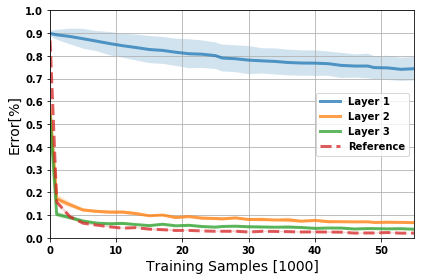

In [22]:
plot_accuracy(all_layers_folders, n_updates_tick=1000)

# Accuracy of the network at the beginning

(n_runs, n_epoch/test_interval, n_batch_test, n_layers): (4, 50, 24, 3)
number of trained weights: 57232 bias: 72
number of test samples: 1536
0.921875
Accuracy: [0.46630859 0.6031901  0.6936849  0.75097656 0.74576823 0.74886068
 0.78938802 0.80533854 0.81656901 0.83398438 0.81787109 0.84798177
 0.84602865 0.85953776 0.86653646 0.86149089 0.86653646 0.86979167
 0.87711589 0.87841797 0.88623047 0.87190755 0.87972005 0.89013672
 0.88460286 0.88671875 0.8819987  0.87906901 0.88574219 0.89339193
 0.89583333 0.8889974  0.89013672 0.89485677 0.89713542 0.89176432
 0.90201823 0.89632161 0.89990234 0.91048177 0.91064453 0.91357422
 0.91031901 0.89550781 0.91113281 0.91097005 0.91552734 0.90413411
 0.91064453 0.91178385]
Accuracy ref: [0.13216146 0.17366536 0.20735677 0.32698568 0.35693359 0.44075521
 0.56315104 0.53157552 0.58349609 0.64550781 0.63346354 0.72200521
 0.68945313 0.71809896 0.76464844 0.75813802 0.77490234 0.79101562
 0.79296875 0.80745443 0.79589844 0.80582682 0.79589844 0.81494

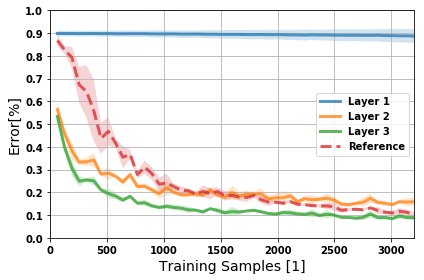

In [23]:
plot_accuracy(all_layers_begin_folders, comment="_begin")

In [31]:
acc_test = [ np.load(path.join(d, "acc_test.npy")) for d in all_layers_folders ]
acc_test = np.array(acc_test)

In [9]:
acc_test

array([[[[0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         ...,
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375]],

        [[0.0625  , 0.5625  , 0.78125 ],
         [0.0625  , 0.5625  , 0.78125 ],
         [0.0625  , 0.5625  , 0.78125 ],
         ...,
         [0.0625  , 0.5625  , 0.796875],
         [0.0625  , 0.5625  , 0.796875],
         [0.0625  , 0.5625  , 0.796875]],

        [[0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         ...,
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ]],

        ...,

        [[0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.9375  , 1.      ],
         ...,
         [0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.

In [10]:
acc_test.shape

(10, 30, 24, 3)

In [12]:
np.mean(acc_test, axis=2).shape

(10, 30, 3)

In [27]:
all_layers_folders[0]

'../Paper_results/001__01-10-2018'